# Lab 4 
## Session IV: Ootimizers and CNNs
Instructor: [Malgorzata Bogdan](https://portal.research.lu.se/en/persons/malgorzata-bogdan), [Najmeh Abiri](https://portal.research.lu.se/en/persons/najmeh-abiri), [Krzysztof Podgorski](https://krys.neocities.org),  [Statistics, Lund University, LUSEM](https://www.stat.lu.se/)
* For more information visit the [CANVAS class website](https://canvas.education.lu.se/courses/22875).

In this session, we compare different optimizers' results on a toy dataset. Further, we design several convolutional neural networks as classifiers for the Fashion_MNIST dataset.

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  ## To turn off debugging information 

import tensorflow as tf
#tf.config.experimental.set_visible_devices([], 'GPU')
# tf.config.set_visible_devices([],'GPU')

import time
%matplotlib inline

In [218]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Optimization

In lecture_08, we saw the effect of **batch sizes** on the training/validation loss of the gradient descent algorithm on a toy dataset.

In [219]:
def syn1(N):
    """ data(samples, features)"""
    
    global seed
    
    data = np.empty(shape=(N,2), dtype = np.float32)  
    tar = np.empty(shape=(N,), dtype = np.float32) 
    N1 = int(N/2)
  
    data[:N1,0] = 2 + np.random.normal(loc=.0, scale=1., size=(N1))
    data[N1:,0] = -2 + np.random.normal(loc=.0, scale=1., size=(N-N1))
    data[:,1] = 10*np.random.normal(loc=.0, scale=1., size=(N))
    
    
    data = data / data.std(axis=0)
    
    # Target
    tar[:N1] = np.ones(shape=(N1,))
    tar[N1:] = np.zeros(shape=(N-N1,))
    tar = np.expand_dims(tar,axis = 1 )
    # Rotation
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c,-s],[s,c]]) # rotation matrix
    data = np.dot(data,R) 
    
    return data,tar

### Task 1 
Repeat the analysis but now time each of the training parts (only time the `model.fit()` function). To do that, use the `Time` package imported in the cell above.

2023-03-19 15:00:19.296118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-19 15:00:22.066721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The time needed to fit model 1 (All data):  7.189786195755005  seconds


2023-03-19 15:00:26.329665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-19 15:00:30.353545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


The time needed to fit model 2 (Mini batch):  24.187258005142212  seconds
The time needed to fit model 3 (SGD):  436.2081296443939  seconds


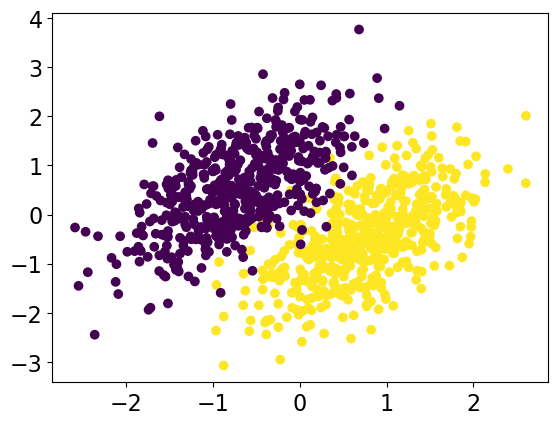

In [220]:
# Generate train data
x_train, y_train = syn1(1000)
# Plot data
plt.scatter(x_train[:,0],x_train[:,1], c=y_train);
# Generate test data
x_test, y_test = syn1(100)

def make_model(opt_method, lr_rate):
    ## define the model
    classifier = tf.keras.Sequential(name='syn_data')
    classifier.add(tf.keras.Input(shape=(2,)))
    classifier.add(tf.keras.layers.Dense(5, activation='relu'))
    classifier.add(tf.keras.layers.Dense(1, activation='sigmoid'))


    ## Compile the model
    method = getattr(tf.keras.optimizers, opt_method)
    
    classifier.compile(optimizer = method(learning_rate = lr_rate),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])   

    return classifier

# def make_modeltaask3 ():
    
#     inp = tf.keras.Input(2)
#     l2 = tf.keras.layers.Dense(4, activation='relu')(inp)
#     l3 = tf.keras.layers.Dense(4, activation='relu')(l2)
#     output = tf.keras.layers.Dense(1, activation='sigmoid')(l3)
    
#     model = tf.keras.models.Model(inp, output)
#     return model
# Fit models with different batch sizes
model1 = make_model('SGD', 0.1)
begin_time = time.time()
report = model1.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= x_train.shape[0], # all data = Batch GD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 1 (All data): ", end_time - begin_time, " seconds")

model2 = make_model('SGD', 0.1)
begin_time = time.time()
report_mb = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 32, # smaller chunks = Mini-BGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 2 (Mini batch): ", end_time - begin_time, " seconds")

model3 = make_model('SGD', 0.1)
begin_time = time.time()
report_b = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 1, # SGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 3 (SGD): ", end_time - begin_time, " seconds")

From the results we can see that the first model, where all data is used, needs the least amount of time to run and the last model, using only one observation at a time, needs the most time to fit.

### Task 2
Repeat the same study with **two** other optimization:

    * Adam
    * RMSprop

What is the effect of batch size in each of these models?


In [ ]:
# Repeating the same study using Adam

# Fit models with different batch sizes
model1 = make_model('Adam', 0.1)
begin_time = time.time()
report = model1.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= x_train.shape[0], # all data = Batch GD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 1: ", end_time - begin_time, " seconds")

model2 = make_model('Adam', 0.1)
begin_time = time.time()
report_mb = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 32, # smaller chunks = Mini-BGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 2: ", end_time - begin_time, " seconds")

model3 = make_model('Adam', 0.1)
begin_time = time.time()
report_b = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 1, # SGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 3: ", end_time - begin_time, " seconds")

The time needed to fit model 1:  3.3545963764190674  seconds
The time needed to fit model 2:  7.206806421279907  seconds
The time needed to fit model 3:  125.07614970207214  seconds


In [ ]:
# Repeating the same study using RMSprop

# Fit models with different batch sizes
model1 = make_model('RMSprop', 0.1)
begin_time = time.time()
report = model1.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= x_train.shape[0], # all data = Batch GD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 1: ", end_time - begin_time, " seconds")

model2 = make_model('RMSprop', 0.1)
begin_time = time.time()
report_mb = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 32, # smaller chunks = Mini-BGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 2: ", end_time - begin_time, " seconds")

model3 = make_model('RMSprop', 0.1)
begin_time = time.time()
report_b = model2.fit(x_train, y_train, 
                         epochs=100, 
                         validation_data=(x_test, y_test),
                         batch_size= 1, # SGD
                         verbose=0)
end_time = time.time()
print("The time needed to fit model 3: ", end_time - begin_time, " seconds")

The time needed to fit model 1:  3.401756763458252  seconds
The time needed to fit model 2:  7.017936944961548  seconds
The time needed to fit model 3:  122.65308046340942  seconds


The effect of the batch size with all three optimizations is similar. The first model, where all data is used, needs the least amount of time to run and the last model, using only one observation at a time, needs the most time to fit.

### Task 3

With the toy dataset, try three different optimization methods:
    1. SGD
    2. Adam
    3. RMSprop
With a similar setup, NN architecture, learning rates, and hyperparameters, 
* First, calculate the time for each optimization.
* Then, plot their loss results for both the training and validation dataset.

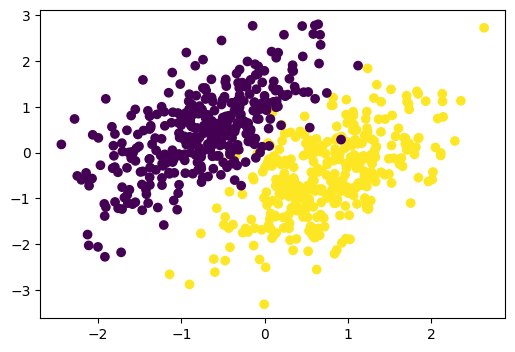

In [ ]:
x_train1,y_train1 = syn1(700)
plt.figure(figsize=(6,4))
plt.scatter(x_train1[:,0],x_train1[:,1], c=y_train1);

The next cell contains a function that returns a model. You can change the architecture.
The different optimization methods are defined afterwards.

In [ ]:
def make_model():
    
    inp = tf.keras.Input(2)
    l2 = tf.keras.layers.Dense(4, activation='relu')(inp)
    l3 = tf.keras.layers.Dense(4, activation='relu')(l2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(l3)
    
    model = tf.keras.models.Model(inp, output)
    return model

In the next cell, we loop around all the models with their different optimizations and time the training part. We also collect the report in an empty list.

Here we plot the loss for the models.

* which one of the methods is the fastest with your setup?
* which method gives the best results. print their loss on the validation dataset.
* Does the fastest to finish the iteration shows the best results? 
* Change the model's hyperparameters and architecture and repeat these experiments.

In [ ]:
all_reports = [] # to save models with different optimizer
evaluation = [] # to save evaluations of the models
lr=1e-2
all_opt = {'sgd': tf.keras.optimizers.SGD(learning_rate=lr),
           'adam':  tf.keras.optimizers.Adam(learning_rate=lr),
           'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=lr)}

for i,opt in all_opt.items():
    

    model = make_model()
    model.compile(optimizer=opt,
              loss='binary_crossentropy')
    start = time.process_time()
    all_reports.append(model.fit(x_train1, y_train1,
                      epochs = 200,
                      validation_data=(x_test, y_test),
                      batch_size= None, # If None or unspecified it is 32 
                      verbose = 0))
    end = time.process_time() - start
    # Evaluate the model on the test set
    evaluation.append(model.evaluate(x_test, y_test, verbose=2))
    print('Time for optimizer {} is {}'.format(i,end) )
    

4/4 - 0s - loss: 0.0838 - 23ms/epoch - 6ms/step
Time for optimizer sgd is 4.421875
4/4 - 0s - loss: 0.0643 - 23ms/epoch - 6ms/step
Time for optimizer adam is 4.875
4/4 - 0s - loss: 0.0614 - 23ms/epoch - 6ms/step
Time for optimizer rmsprop is 4.921875


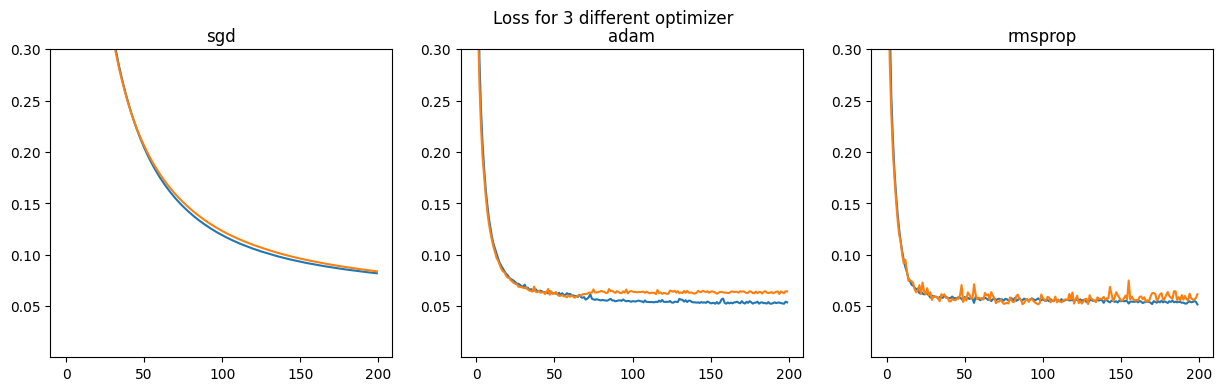

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 4))
fig.suptitle('Loss for 3 different optimizer')
plt.setp(axs,  ylim=[0.0001,0.3])
for i,ax in enumerate(axs):
    ax.plot(all_reports[i].history['loss'])
    ax.plot(all_reports[i].history['val_loss'])
    ax.title.set_text(list(all_opt.keys())[i])
## NOTE: if you don't see the whole loss change the range of ylim in line 3 of this cell

From the results we can see that the time needed for all three optimizers is very similar. However, the fastest optimizer is sgd and the slowest is rmsprop.

In [ ]:
# Print the evaluation of the models on the test data
evaluation

[0.0837860181927681, 0.0642707496881485, 0.061409782618284225]

From the results we can see that the model, which has the lowest loss, is fitted using RMSprop optimizer. Therefore, the model which is the fastest to finish the iteration does not show the best results.

We will change model's hyperparameters and architecture and repeat the same steps. 

In [ ]:
def make_model():
    
    inp = tf.keras.Input(2)
    l2 = tf.keras.layers.Dense(3, activation='tanh')(inp)
    l3 = tf.keras.layers.Dense(4, activation='tanh')(l2)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(l3)
    
    model = tf.keras.models.Model(inp, output)
    return model

all_reports = [] # to save models with different optimizer
evaluation = [] # to save evaluations of the models
lr=1e-3
all_opt = {'sgd': tf.keras.optimizers.SGD(learning_rate=lr),
           'adam':  tf.keras.optimizers.Adam(learning_rate=lr),
           'rmsprop': tf.keras.optimizers.RMSprop(learning_rate=lr)}

for i,opt in all_opt.items():
    

    model = make_model()
    model.compile(optimizer=opt,
              loss='binary_crossentropy')
    start = time.process_time()
    all_reports.append(model.fit(x_train1, y_train1,
                      epochs = 200,
                      validation_data=(x_test, y_test),
                      batch_size= None, # If None or unspecified it is 32 
                      verbose = 0))
    end = time.process_time() - start
    # Evaluate the model on the test set
    evaluation.append(model.evaluate(x_test, y_test, verbose=2))
    print('Time for optimizer {} is {}'.format(i,end) )

4/4 - 0s - loss: 0.1589 - 25ms/epoch - 6ms/step
Time for optimizer sgd is 4.640625
4/4 - 0s - loss: 0.0598 - 25ms/epoch - 6ms/step
Time for optimizer adam is 5.0
4/4 - 0s - loss: 0.0565 - 24ms/epoch - 6ms/step
Time for optimizer rmsprop is 5.09375


From the results we can see that the time needed for all three optimizers is very similar. However, the fastest optimizer is SGD and the slowest is RMSprop.

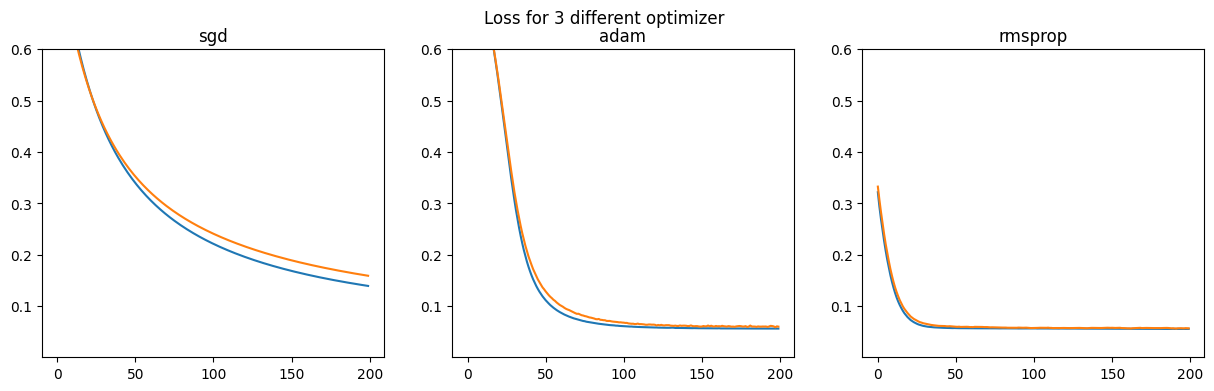

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 4))
fig.suptitle('Loss for 3 different optimizer')
plt.setp(axs,  ylim=[0.0001,0.6])
for i,ax in enumerate(axs):
    ax.plot(all_reports[i].history['loss'])
    ax.plot(all_reports[i].history['val_loss'])
    ax.title.set_text(list(all_opt.keys())[i])
## NOTE: if you don't see the whole loss change the range of ylim in line 3 of this cell

In [221]:
# Print the evaluation of the models on the test data
round(evaluation, 2)

NameError: name 'evaluation' is not defined

From the results we can see that models fitted using RMSprop and Adam gives quite similar losses while SGD has a significantly higher loss. The model, which has the lowest loss, is fitted using RMSprop optimizer. Therefore, the model which is the fastest to finish the iteration does not show the best results.

Comapared to the results of the previous neural net, different optimizers give quite similar resuls in terms of their fitting time. However, RMSprop gives the lowest loss. 

## CNN

This section will study convolutional neural networks and their characteristics in image analysis.
To do that, we use a dataset of clothing (made by Zalando) named **Fashion-MNIST**. 
 * It consists of a training set of 60,000 examples and a test set of 10,000.
 * The images are 28*28 pixels in grayscale (one color channel).
 
Let's load the dataset:

In [228]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
 
# rescale image
x_train = x_train / 255.0
x_test = x_test / 255.0

### Task 4
What are the dimensions, and are the classes equally distributed?
Are the classes equally distributed in the test dataset? What is the percentage of each class in training and test datasets?

In [135]:
print("Fashion MNIST train -  rows:",x_train.shape," labels:", y_train.shape)
print("Fashion MNIST test -  rows:",x_test.shape," labels:", y_test.shape)

Fashion MNIST train -  rows: (60000, 28, 28)  labels: (60000,)
Fashion MNIST test -  rows: (10000, 28, 28)  labels: (10000,)


The dimensions of the training set is 60000 x 28 x 28 which means that there are 60000 observations made out of pictures with $28*28$ pixels. The dimensions of the test set is 10000 x 28 x 28 which means that there are 10000 observations made out of pictures with $28*28$ pixels.

In [136]:
# Calculate the number of unique observations in the labels of the training dataset
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [137]:
# Calculate the number of unique observations in the labels of the test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

From the results we can see that classes in the training and test datasets are equally distributed because each class has 6000 observations in the training dataset and each class has 1000 observations in the test dataset. The percentage of each class in training and test datasets is 10%.

Let's plot some random samples from the training dataset with their labels.

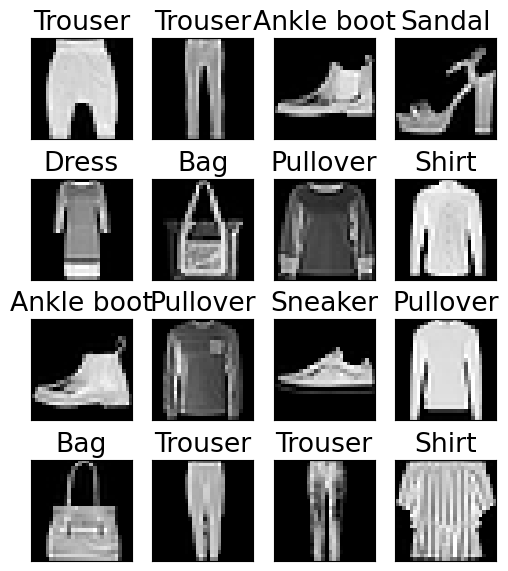

In [138]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


def dis_img(x,y, labeldict, title = None):
    
    indx = np.random.choice(range(x.shape[0]) , 16 )   
    fig, ax = plt.subplots(4, 4,
                           figsize=(6,7),
                           subplot_kw={'xticks': [], 'yticks': []},
                           num= title )      
    imag = [ (x[ind],y[ind])  for ind in indx] 
    for coef, ax in zip(imag, ax.ravel()):
        ax.imshow(coef[0].reshape(28, 28), cmap=plt.cm.gray)     
        ax.set_title(labeldict[coef[1]])
        
dis_img(x_train,y_train, labeldict,'random_samples')


### Task 5

In this task, we train a CNN and will observe the feature maps of the convolutional layers.

First, design a CNN with at least two convolutional layers. Then we fit the model to the scaled dataset and plot the training loss. Note that you can define a portion of your training dataset to get used as validation via:
```python
validation_split=0.2
```
in `model.fit()` function. Here we set validation_split to $0.2$, which means $20\%$ of the training set will be assigned for validation.


In [145]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28, 28, 1), filters=16, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(228, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
 
model_cnn.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy")

model_cnn.summary() 

# Experimenting with another model
model_cnn_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3), input_shape=(28, 28, 1), padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(228, activation="tanh"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
 
model_cnn_2.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_11 (Dense)            (None, 228)               715236    
                                                      

In [146]:
report_cnn = model_cnn.fit(x_train, y_train,
                  batch_size=32,
                  validation_split=0.3,
                  epochs=10,
                  verbose=2)


Epoch 1/10


2023-03-18 18:58:12.685003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 18:58:23.692971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1313/1313 - 13s - loss: 0.5234 - val_loss: 0.3627 - 13s/epoch - 10ms/step
Epoch 2/10
1313/1313 - 12s - loss: 0.3429 - val_loss: 0.2987 - 12s/epoch - 9ms/step
Epoch 3/10
1313/1313 - 12s - loss: 0.2871 - val_loss: 0.2734 - 12s/epoch - 9ms/step
Epoch 4/10
1313/1313 - 10s - loss: 0.2547 - val_loss: 0.2714 - 10s/epoch - 8ms/step
Epoch 5/10
1313/1313 - 10s - loss: 0.2279 - val_loss: 0.2465 - 10s/epoch - 8ms/step
Epoch 6/10
1313/1313 - 11s - loss: 0.2097 - val_loss: 0.2405 - 11s/epoch - 8ms/step
Epoch 7/10
1313/1313 - 11s - loss: 0.1941 - val_loss: 0.2305 - 11s/epoch - 9ms/step
Epoch 8/10
1313/1313 - 12s - loss: 0.1782 - val_loss: 0.2300 - 12s/epoch - 9ms/step
Epoch 9/10
1313/1313 - 11s - loss: 0.1671 - val_loss: 0.2156 - 11s/epoch - 9ms/step
Epoch 10/10
1313/1313 - 12s - loss: 0.1585 - val_loss: 0.2337 - 12s/epoch - 9ms/step


In [147]:
# Experimenting by training another model
report_cnn_2 = model_cnn_2.fit(x_train, y_train,
                  batch_size=32,
                  validation_split=0.2,
                  epochs=10,
                  verbose=2)

Epoch 1/10


2023-03-18 19:00:09.010703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-18 19:00:21.886978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1500/1500 - 14s - loss: 0.4499 - val_loss: 0.3171 - 14s/epoch - 10ms/step
Epoch 2/10
1500/1500 - 12s - loss: 0.3182 - val_loss: 0.2927 - 12s/epoch - 8ms/step
Epoch 3/10
1500/1500 - 12s - loss: 0.2737 - val_loss: 0.2584 - 12s/epoch - 8ms/step
Epoch 4/10
1500/1500 - 13s - loss: 0.2483 - val_loss: 0.2500 - 13s/epoch - 9ms/step
Epoch 5/10
1500/1500 - 13s - loss: 0.2248 - val_loss: 0.2448 - 13s/epoch - 9ms/step
Epoch 6/10
1500/1500 - 12s - loss: 0.2061 - val_loss: 0.2426 - 12s/epoch - 8ms/step
Epoch 7/10
1500/1500 - 11s - loss: 0.1922 - val_loss: 0.2236 - 11s/epoch - 7ms/step
Epoch 8/10
1500/1500 - 12s - loss: 0.1779 - val_loss: 0.2299 - 12s/epoch - 8ms/step
Epoch 9/10
1500/1500 - 12s - loss: 0.1650 - val_loss: 0.2286 - 12s/epoch - 8ms/step
Epoch 10/10
1500/1500 - 11s - loss: 0.1533 - val_loss: 0.2361 - 11s/epoch - 7ms/step


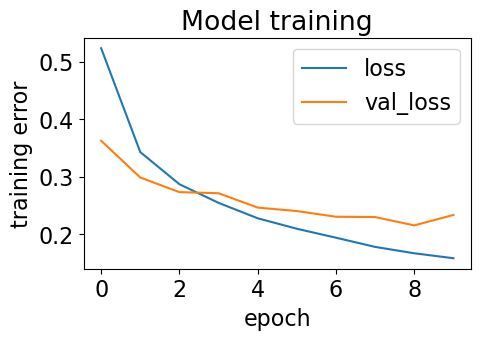

In [148]:
plt.figure( figsize=(5,3))
for k in report_cnn.history.keys():
    plt.plot(report_cnn.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='best');

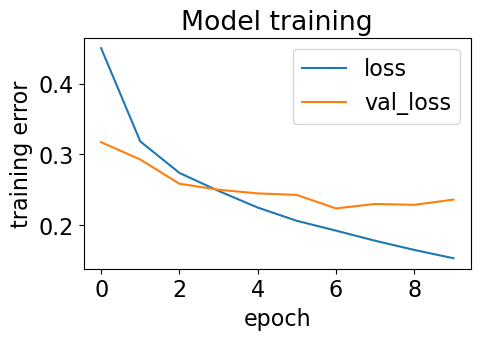

In [149]:
# Experimenting by plotting the error of another model
plt.figure( figsize=(5,3))
for k in report_cnn_2.history.keys():
    plt.plot(report_cnn_2.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='best');

Model has all its layers in the `model_cnn.layers` list. Find the Conv layars and print the shapes of their kernel and filters. 

In [150]:
print(model_cnn.layers[0].kernel.shape)
print(model_cnn.layers[0].filters)
print(model_cnn.layers[2].kernel.shape)
print(model_cnn.layers[2].filters)

(3, 3, 1, 16)
16
(3, 3, 16, 16)
16


In our trained model we have 2 convolutional layers with the same dimensions. The shape of their kernel is 3x3 and they have 16 filters.

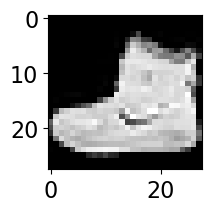

In [151]:
plt.figure(figsize=(2,2))
plt.imshow(x_train[0],cmap='gray');

In [227]:
def plot_layer(x = None,
                num_layer= None,
                model = None): 
    """
    x : The data point you what to see its feature maps x_train[0]
    num_layer: The index of the conv2D layer
    model: 
    ##########
    ##########
    This function is written for conv2D with 16 filters.
    In case of a higher or lower number of filters, 
    one needs to adjust the subplot numbers (row, column) accordingly.
    """
    # Extract output from each layer
    extractor = tf.keras.Model(inputs=model.inputs,
                           outputs=[layer.output for layer in model.layers])
    features = extractor(np.expand_dims(x, 0))
    # feature maps from the layer
    l0_features = features[num_layer].numpy()[0]
    fig, ax = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(16,4))
    for i in range(0, 16):
        row, col = i//8, i%8
        ax[row][col].imshow(l0_features[..., i],cmap='gray')

    plt.show()


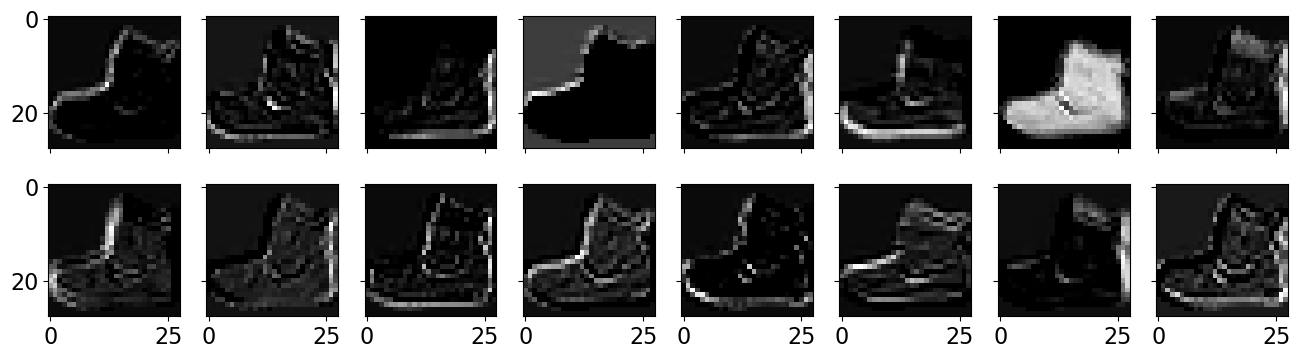

In [153]:
plot_layer(x_train[0], 0, model_cnn)

### Task 6
Use the `plot_leyer` function for the second convolutional layer. What is the difference between the images from the first vs. second convolutional layer?

Try the same function on the max-pooling layer. What is happening to the images?

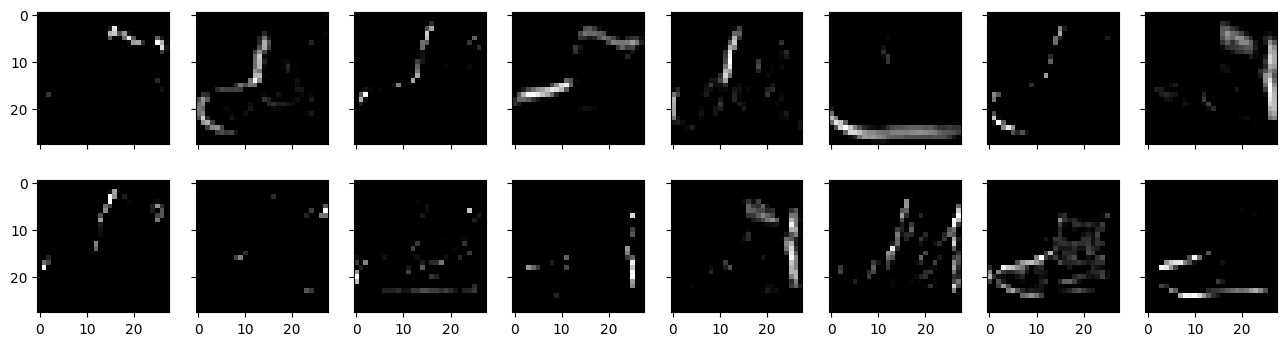

In [ ]:
plot_layer(x_train[0], 2, model_cnn)

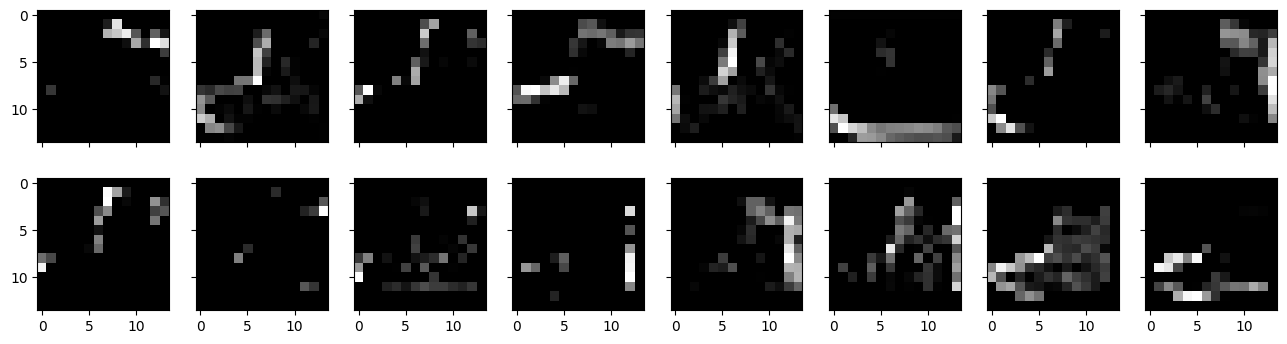

In [ ]:
plot_layer(x_train[0], 3, model_cnn)

From the results we can see that in the first convolutional layer images are clearer while in the second convolutional layer we can see only the contours of the shoes. In the images from the max-pooling layer it is difficult to distinguish the shoes and only some points of the shoes are brighter. 

### Task 7

Design three different CNN to classify all classes. Use regularization methods, other architectures, and hyperparameters.
Apply **1-fold cross-validation** and report your test errors.

#### Model 1

Changes versus original CNN:

* softmax instead of sigmoid function
* Average Pooling after the first layer

In [ ]:
model_cnn1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
    kernel_size=(3,3), input_shape=(28, 28, 1), padding="same", activation="relu"),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(228, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
 
model_cnn1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy", 
              metrics = ['accuracy'])

model_cnn1.summary() 
report_cnn1 = model_cnn1.fit(x_train, y_train,
                  batch_size=32,
                  validation_split=0.1,
                  epochs=5,
                  verbose=2)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 16)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 16)        2320      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 784)              

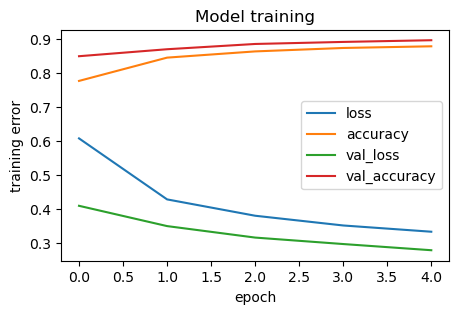

In [ ]:
plt.figure( figsize=(5,3))
for k in report_cnn1.history.keys():
    plt.plot(report_cnn1.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='best')

#### Model 2

Changes versus original CNN:

* softmax instead of sigmoid function
* CHanges in droput paramaters
* Adding L2 regularizer on the last hidden layer

In [ ]:
from tensorflow.keras import regularizers
model_cnn2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
    kernel_size=(3,3), input_shape=(28, 28, 1), padding="same", activation="relu"),
    # tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(228, activation="relu", kernel_regularizer=regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])
 
model_cnn2.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])

model_cnn2.summary() 
report_cnn2 = model_cnn2.fit(x_train, y_train,
                  batch_size=32,
                  validation_split=0.1,
                  epochs=5,
                  verbose=1)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 dropout_16 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 3136)              0         
                                                                 
 dense_19 (Dense)            (None, 228)               715236    
                                                      

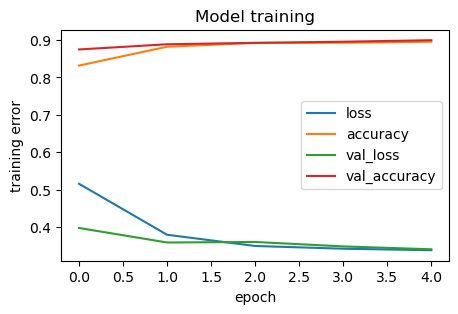

In [ ]:
plt.figure( figsize=(5,3))
for k in report_cnn2.history.keys():
    plt.plot(report_cnn2.history[k], label = k)
plt.title('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
plt.legend(loc='best')

#### Model 3

Changes versus original CNN:

* softmax function
* Changes in droput paramaters 0.2 and 0.5
* Adding L2 regularizer on the last hidden layer
* Adding second hidden layer and reducing number of nodes for last 2 layers
* RMSprop optimization method
* Changing validation set size to 10%


In [ ]:
from tensorflow.keras import regularizers
model_cnn3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, 
    kernel_size=(3,3), input_shape=(28, 28, 1), padding="same", activation="relu"),
    # tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(16, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(114, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(114, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
 
model_cnn3.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",  
              metrics=['accuracy'])

model_cnn3.summary() 
report_cnn3 = model_cnn3.fit(x_train, y_train,
                  batch_size=32,
                  validation_split=0.1,
                  epochs=5,
                  verbose=1)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_14 (Dense)            (None, 114)               357618    
                                                      

In [ ]:
import inspect
import pandas as pd
models = [model_cnn1, model_cnn2, model_cnn3]
evaluation_metrics = [model.evaluate(x_test, y_test, verbose=2) for model in models]
evaluation_metrics_val_loss = [i[0] for i in evaluation_metrics]
evaluation_metrics_val_accuracy = [i[1] for i in evaluation_metrics]

pd.DataFrame({
    "model names":["Model 1", "Model 2", "Model 3"], 
    "validation loss":evaluation_metrics_val_loss, 
    "validation accuracy":evaluation_metrics_val_accuracy
})

313/313 - 0s - loss: 0.2585 - accuracy: 0.9051 - 437ms/epoch - 1ms/step
313/313 - 0s - loss: 0.3662 - accuracy: 0.8943 - 482ms/epoch - 2ms/step
313/313 - 1s - loss: 0.3338 - accuracy: 0.8989 - 685ms/epoch - 2ms/step


,model names,validation loss,validation accuracy
0,Model 1,0.258510,0.9051
1,Model 2,0.366226,0.8943
2,Model 3,0.333777,0.8989


From the results we can see that the first CNN model has the highest accuracy and the lowest loss when evaluating the model on the test data compared to other models. The first CNN has 2 convolutional layers with 10 filters and a kernel size of 3x3 and two drop-out layers. Moreover, the chosen optimizer is Adam.

# CNN implementation for Hurricane damage classiification

### Importing libraries

In [21]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
os.getcwd()
from glob import glob
import random
# import seaborn as sns
pd.set_option('display.max_colwidth', None)
import datetime

In [22]:
img_paths=[]
img_labels=[]
for i in glob('archive/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [23]:
len(img_paths),len(img_labels)

(23000, 23000)

In [24]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
10323,archive/train_another/damage/-95.670441_29.810896000000003.jpeg,damage
22498,archive/test_another/damage/-96.90783499999999_28.830168.jpeg,damage
8918,archive/train_another/no_damage/-95.65283199999999_29.837958.jpeg,no_damage
13909,archive/train_another/damage/-95.167377_29.437222.jpeg,damage
15443,archive/test_another/damage/-95.535877_29.750364.jpeg,damage


#### Value counts for classes
We can see that ther is no huge gap between classes. Data set is moderately imbalanced

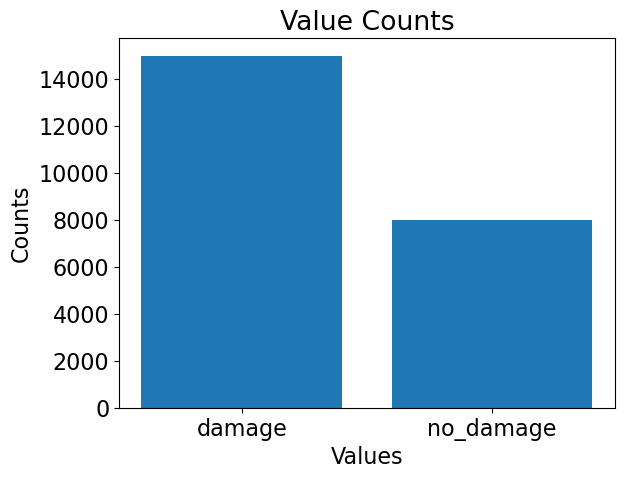

In [205]:

# assuming your data is a Pandas Series object called 'data'
value_counts = data[1].value_counts()

# create a bar plot
plt.bar(value_counts.index, value_counts.values)

# set the plot title and axis labels
plt.title('Value Counts')
plt.xlabel('Values')
plt.ylabel('Counts')

# display the plot
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [175]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

train_gen = ImageDataGenerator(
        validation_split=0.1,
        rescale=1/255,
        ) 

test_gen = ImageDataGenerator(
    rescale=1/255
)

data_train = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=32,
    seed=2020
)

data_val = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=32,
    seed=2020
)

data_test = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=32,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


### Importing images

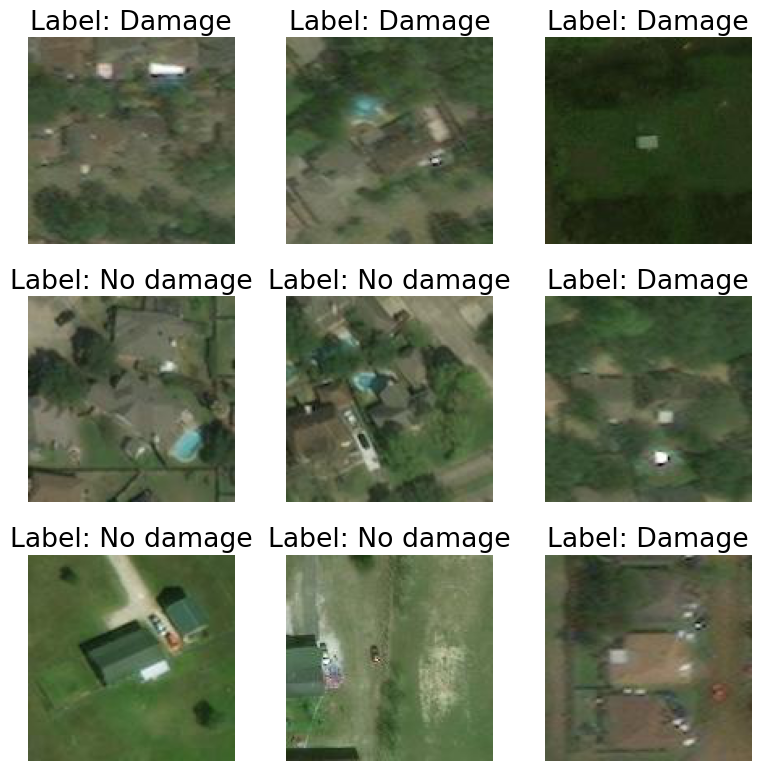

In [176]:
import matplotlib.pyplot as plt

# retrieve first batch from data generator
batch_images, batch_labels = next(data_train)

label_dict = {
    0: "Damage", 
    1: "No damage"
}

# plot 9 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch_images[i])
    ax.axis('off')
    ax.set_title(f'Label: {label_dict[batch_labels[i].argmax()]}')
plt.tight_layout()
plt.show()

## AlexNet

### AlexNet explanation

### AlexNet

**AlexNet modified architecture:**

<img src="AlexNet architecture.png" alt="AlexNet architecture" width="1000"/>

$$
C N N \rightarrow R N \rightarrow M P)^2 \rightarrow\left(C N N^3 \rightarrow M P\right) \rightarrow(F C \rightarrow D O)^2 \rightarrow \text { Linear } \rightarrow \text { sigmoid }
$$

Where

- $CNN$ = convolutional layer (with ReLU activation)
- $RN$ = local response normalization
- $MP$ = maxpooling
- $FC$ = fully connected layer (with ReLU activation)
- $Linear$ = fully connected layer (without activation)
- $DO$ = dropout

**********************Key points:**********************

1. ReLu activation function is used instead of Tanh to add non-linearity. It accelerates the speed by 6 times at the same accuracy.
2. Use dropout instead of regularisation to deal with overfitting. However, the training time is doubled with the dropout rate of 0.5.
3. Overlap pooling to reduce the size of the network. 

**Reduction of overfitting:**

1. Dropouts of 50% on two Fully connected layers at the end
2. Testing 40 different combinations of optimization methods (Adam, RMSprop, SGD) and learning rates
3. EarlyStopping  with patience for 1 epoch and min $\Delta = 0.01$ in validation accuracy metric

Data augmentation is common technique to reduce overfitting, however we didn’t use due to computational limitations. We already found that our model does not overfit with comparing accuracy results on validation dataset and testing dataset

Krizhevsky, A., Sutskever, I. and Hinton, G.E. (2017) “ImageNet classification with deep convolutional Neural Networks,” Communications of the ACM, 60(6), pp. 84–90. Available at: https://doi.org/10.1145/3065386. 

### AlexNet application

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam


In [38]:
learning_rates = list(np.logspace(-7, -4, 20))
print(learning_rates)

[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]


In [41]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

def create_model_alexnet(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    # model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # model.optimizer.learning_rate = hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]
)
    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam', 'sgd', "rmsprop"])
# tuner_hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
# tuner_hp.Choice('learning_rate', values=[1e-7, 1e-6, 1e-5, 1e-4])
tuner_hp.Choice('learning_rate', values=[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]
)

# Create the tuner object
tuner = RandomSearch(
    create_model_alexnet,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=40,
    # executions_per_trial=3,
    overwrite = True,
    project_name='my_project')

now = datetime.datetime.now()
log_dir = f"./logs_alexnet_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

# Add a ModelCheckpoint callback to save the best model during training
checkpoint_filepath = f"model_checkpoints/best_model_{now.strftime('%Y.%m.%d_%H.%M')}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    mode = "max", 
    # start_from_epoch=2,
    min_delta=0.01
    )

# Run the search
tuner.search(data_train, 
             epochs=20, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping, checkpoint_callback]
             )

Trial 37 Complete [00h 06m 01s]
val_accuracy: 0.8689855337142944

Best val_accuracy So Far: 0.9518840909004211
Total elapsed time: 03h 11m 33s
INFO:tensorflow:Oracle triggered exit


In [42]:
model_alex_best=tuner.get_best_models()[0]

In [43]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
learning_rate = best_hyperparameters.get('learning_rate')
optimizer = best_hyperparameters.get('optimizer')
print(f"Best learning rate: {learning_rate}")
print(f"Best optimizer: {optimizer}")

Best learning rate: 3.7926901907322535e-06
Best optimizer: rmsprop


In [251]:
model_alex_best.evaluate(data_test, verbose=2)

2023-03-19 22:27:32.288608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 - 9s - loss: 0.1674 - accuracy: 0.9410 - 9s/epoch - 52ms/step


[0.16735555231571198, 0.9410435557365417]

In [108]:
import sklearn
from sklearn.metrics import confusion_matrix
y_pred_alex = model_alex_best.predict(data_test)
y_proba_alex = np.max(y_pred_alex, axis = 1)
y_prob_1_alex = y_pred_alex[:, 1]
y_pred_bin_alex = np.argmax(y_pred_alex,axis=1)
print(classification_report(data_test.labels,y_pred_bin_alex))

2023-03-18 18:07:55.146780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 4s 19ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3694
           1       0.94      0.90      0.92      2056

    accuracy                           0.94      5750
   macro avg       0.94      0.93      0.94      5750
weighted avg       0.94      0.94      0.94      5750



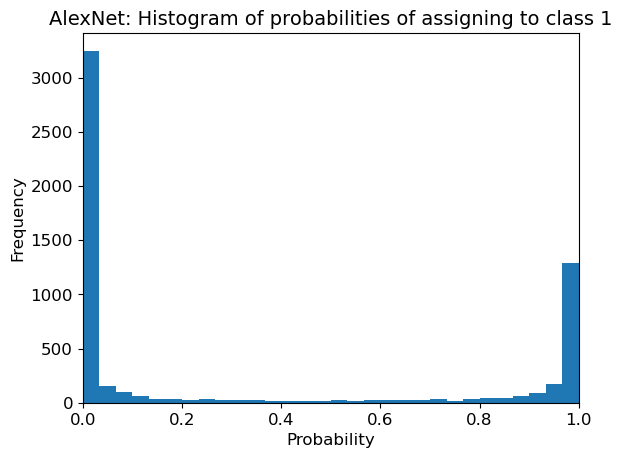

In [116]:
# Plot a histogram
plt.hist(y_prob_1_alex, bins=30)
plt.xlim(0, 1) # set the x limits
plt.title("AlexNet: Histogram of probabilities of assigning to class 1", fontsize=14) # set the title with font size 12
plt.xlabel("Probability", fontsize=12) # set the x label with font size 12
plt.ylabel("Frequency", fontsize=12) # set the y label with font size 12
plt.xticks(fontsize=12) # set the x tick labels with font size 12
plt.yticks(fontsize=12) # set the y tick labels with font size 12
plt.show()

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred_alex = model_alex_best.predict(data_test)
y_proba_alex = np.max(y_pred_alex, axis = 1)
y_prob_1_alex = y_pred_alex[:, 1]
y_pred_bin_alex = np.argmax(y_pred_alex,axis=1)
print(classification_report(data_test.labels,y_pred_bin_alex))

180/180 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3694
           1       0.94      0.90      0.92      2056

    accuracy                           0.94      5750
   macro avg       0.94      0.93      0.94      5750
weighted avg       0.94      0.94      0.94      5750



In [123]:
from sklearn.metrics import confusion_matrix

classes=['Damage','No Damage']
con_mat_df_alex = pd.DataFrame(confusion_matrix(data_test.labels,y_pred_bin_alex),
                     index = classes, 
                     columns = classes)


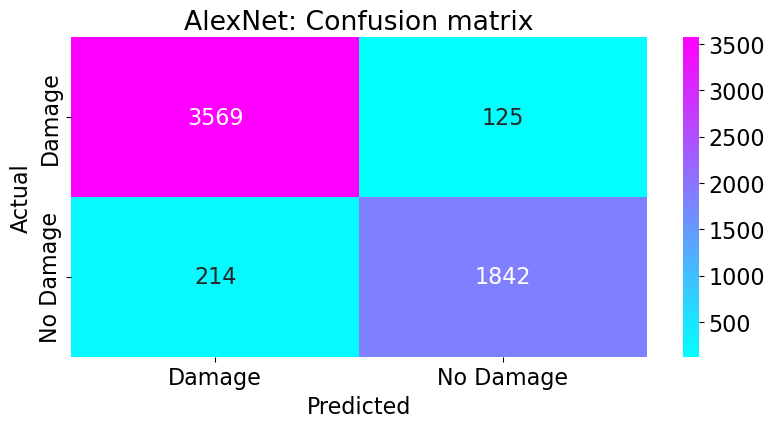

In [125]:
import seaborn as sns
figure = plt.figure(figsize=(8, 4))
sns.heatmap(con_mat_df_alex, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("AlexNet: Confusion matrix") # set the title
plt.show()

In [61]:

#### Evaluation functions for binary classification problems

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# calculate the fpr and tpr for all thresholds of the classification


# Creating a function to report confusion metrics
def confusion_metrics(conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')



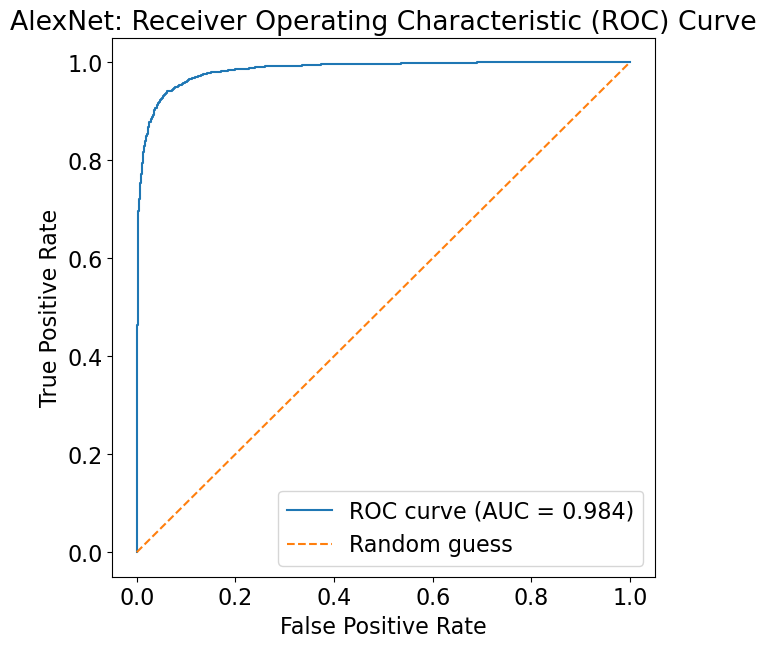

In [121]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_alex, tpr_alex, thresholds_alex = roc_curve(data_test.labels, y_prob_1_alex)
auc_score_alex = roc_auc_score(data_test.labels, y_prob_1_alex)
# Create a figure object with size 9 x 6 inches (1.5 times bigger than the default 6 x 4 inches)
plt.figure(figsize=(7, 7))
# Plot the ROC curve.
plt.plot(fpr_alex, tpr_alex, label=f'ROC curve (AUC = {auc_score_alex:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AlexNet: Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [68]:
con_mat_df_alex.to_numpy()
confusion_metrics(con_mat_df_alex.to_numpy())

True Positives: 1842
True Negatives: 3569
False Positives: 125
False Negatives: 214
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.9
Specificity: 0.97
Precision: 0.94
f_1 Score: 0.92


### Confusion matrix metrics
Here are the explanations of each metric and how they are calculated with LaTeX syntax:

Accuracy: Accuracy measures the overall correctness of the model predictions. It is calculated as the ratio of correctly classified instances to the total number of instances in the dataset.
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

Mis-Classification: Mis-classification is the complement of accuracy and measures the overall incorrectness of the model predictions. It is calculated as the ratio of incorrectly classified instances to the total number of instances in the dataset.
$$Mis-Classification = 1 - Accuracy$$

Sensitivity: Sensitivity (also known as recall or true positive rate) measures the proportion of actual positive instances that are correctly identified by the model. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
$$Sensitivity = \frac{TP}{TP + FN}$$

Specificity: Specificity measures the proportion of actual negative instances that are correctly identified by the model. It is calculated as the ratio of true negatives to the sum of true negatives and false positives.
$$Specificity = \frac{TN}{TN + FP}$$

Precision: Precision measures the proportion of positive predictions that are actually true positive instances. It is calculated as the ratio of true positives to the sum of true positives and false positives.
$$Precision = \frac{TP}{TP + FP}$$

F1 Score: F1 score is the harmonic mean of precision and sensitivity. It provides a balance between precision and sensitivity and is a popular metric for imbalanced datasets where one class is much more frequent than the other.
$$F1 Score = 2 * \frac{Precision * Sensitivity}{Precision + Sensitivity}$$

Overall, these metrics are important for evaluating the performance of a classification model and understanding its strengths and weaknesses. High accuracy, sensitivity, specificity, and precision are desirable, while low mis-classification and a high F1 score indicate a well-performing model.

Our model performs on satisfying level in each metric. While specificty is higher than sensitivity it means that the model has higher performance in classifying that there is no damage to the building than there was damage. As we are more concerned about classifying damaged objects AlexNet should be tuned to have better performance in sensitivity metric (classifying True Positives)





## VGG 16

In [70]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (128, 128, 3)

# create the base model from the pre-trained model VGG16
# note that, if using a Kaggle server, internet has to be turned on
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# freeze the convolutional base
pretrained_model.trainable = False

In [71]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [187]:
list(np.logspace(-6, -3,  20))

[1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001]


In [244]:
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

def create_model_vgg16(hp):
    model = Sequential()
    model.add(VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))# adding dropouts
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))# adding dropouts
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam']),
                                    #   ['adam', 'rmsprop']), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[0.0000029764]
                                            #   [1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001]
                                            #   [1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
                                              )

    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam'#, 'rmsprop'
                                     ])
# tuner_hp.Float('learning_rate', 1e-7, 1e-4, sampling='log')
tuner_hp.Choice('learning_rate', values=[0.0000029764])
                # [1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001])

# Create the tuner object
tuner = RandomSearch(
    create_model_vgg16,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=16,
    # executions_per_trial=3,
    overwrite = True,
    # directory='',
    project_name='my_project')

import datetime
now = datetime.datetime.now()
log_dir = f"./logs_vgg16_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

# Add a ModelCheckpoint callback to save the best model during training
checkpoint_filepath = f"model_checkpoints/best_model_vgg_{now.strftime('%Y.%m.%d_%H.%M')}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    mode = "max", 
    # start_from_epoch=2,
    min_delta=0.0005
    )

# Run the search
tuner.search(data_train, 
             epochs=15, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping, checkpoint_callback]
             )

Trial 1 Complete [00h 40m 29s]
val_accuracy: 0.9802899360656738

Best val_accuracy So Far: 0.9802899360656738
Total elapsed time: 00h 40m 29s
INFO:tensorflow:Oracle triggered exit


We run a parameter tuning procedure but we discovered it will probably take too long so we stopped after 8 trials (8 randomly chosen combinations out of 40 in total in Radom Search) and we picked the model with the highest validation accuracy that was the one with:
- Adam optimizer
- learning rate: 0.0000029764 

Above there is an optimization with only this model

In [169]:
vgg16 = create_model_vgg16(tuner_hp)
import visualkeras

visualkeras.layered_view(vgg16, to_file='output.png') # write 

visualkeras.layered_view(vgg16)

In [190]:
import pickle

# with open("vgg16_2023.03.19_00.02_tuner.pkl", "wb") as f:
#     # Use pickle.dump() to serialize and save your objects to the file
#     pickle.dump(tuner, f)
#     pickle.dump(tuner_hp, f)

In [245]:
model_vgg_best=tuner.get_best_models()[0]
model_vgg_best.evaluate(data_test, verbose=2)

2023-03-19 18:46:42.534125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 - 37s - loss: 0.0501 - accuracy: 0.9810 - 37s/epoch - 204ms/step


[0.05006135627627373, 0.9810435175895691]

In [246]:
import sklearn
from sklearn.metrics import confusion_matrix
y_pred_vgg = model_vgg_best.predict(data_test)
y_proba_vgg = np.max(y_pred_vgg, axis = 1)
y_prob_1_vgg = y_pred_vgg[:, 1]
y_pred_bin_vgg = np.argmax(y_pred_vgg,axis=1)
print(classification_report(data_test.labels,y_pred_bin_vgg))

2023-03-19 18:53:45.463850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 27s 147ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3694
           1       0.98      0.97      0.97      2056

    accuracy                           0.98      5750
   macro avg       0.98      0.98      0.98      5750
weighted avg       0.98      0.98      0.98      5750



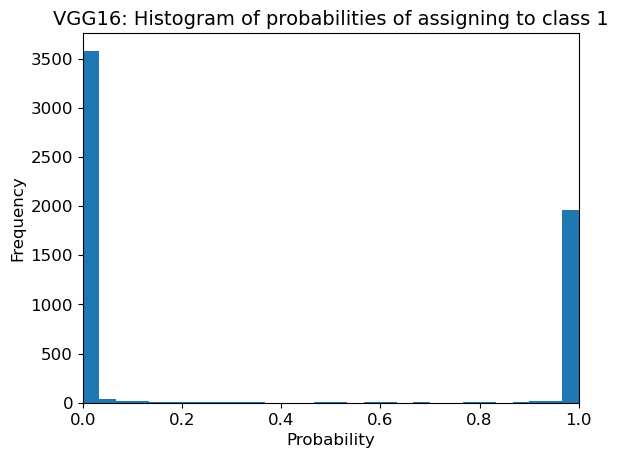

In [117]:
# Plot a histogram
plt.hist(y_prob_1_vgg, bins=30)
plt.xlim(0, 1) # set the x limits
plt.title("VGG16: Histogram of probabilities of assigning to class 1", fontsize=14) # set the title with font size 12
plt.xlabel("Probability", fontsize=12) # set the x label with font size 12
plt.ylabel("Frequency", fontsize=12) # set the y label with font size 12
plt.xticks(fontsize=12) # set the x tick labels with font size 12
plt.yticks(fontsize=12) # set the y tick labels with font size 12
plt.show()

In [247]:
from sklearn.metrics import classification_report, confusion_matrix

classes=['Damage','No Damage']
con_mat_df_vgg = pd.DataFrame(confusion_matrix(data_test.labels,y_pred_bin_vgg),
                     index = classes, 
                     columns = classes)


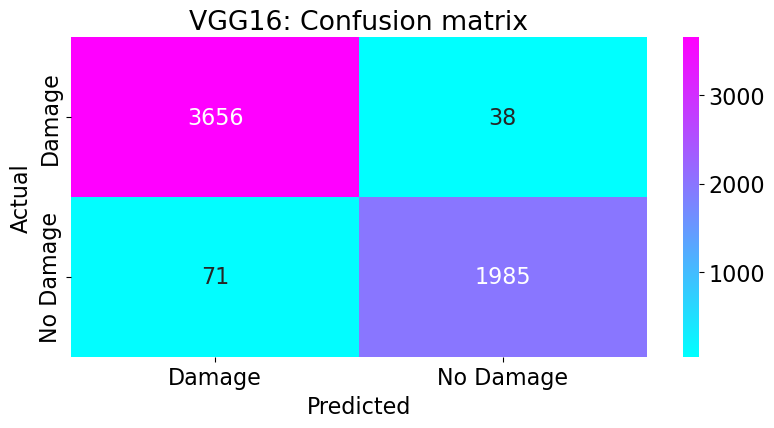

In [248]:
import seaborn as sns
figure = plt.figure(figsize=(8, 4))
sns.heatmap(con_mat_df_vgg, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("VGG16: Confusion matrix") # set the title
plt.show()

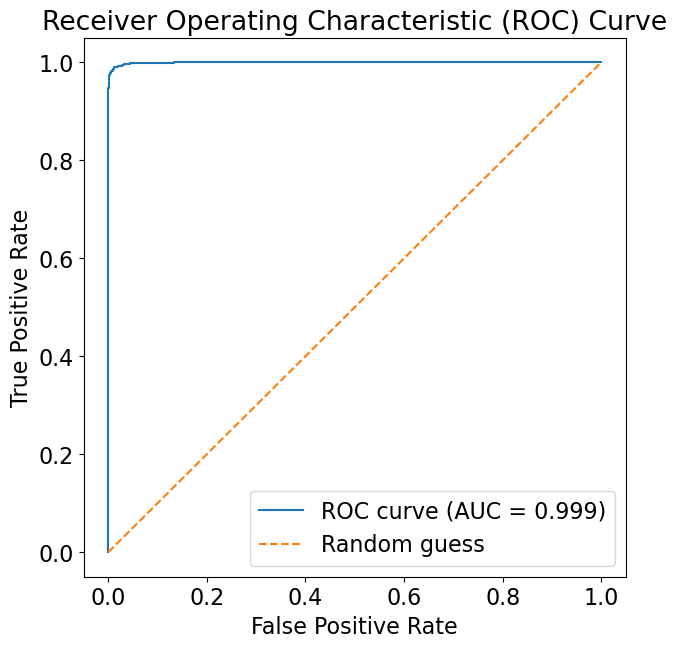

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(data_test.labels, y_prob_1_vgg)
auc_score_vgg = roc_auc_score(data_test.labels, y_prob_1_vgg)
# Create a figure object with size 9 x 6 inches (1.5 times bigger than the default 6 x 4 inches)
plt.figure(figsize=(7, 7))
# Plot the ROC curve.
plt.plot(fpr_vgg, tpr_vgg, label=f'ROC curve (AUC = {auc_score_vgg:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [249]:
con_mat_df_vgg.to_numpy()
confusion_metrics(con_mat_df_vgg.to_numpy())

True Positives: 1985
True Negatives: 3656
False Positives: 38
False Negatives: 71
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.97
Specificity: 0.99
Precision: 0.98
f_1 Score: 0.97
